In [47]:
import os
os.chdir('../data')
######### **1.1** Adding Libraries
import pandas as pd
import numpy as np
import sys
import pickle
pd.options.mode.chained_assignment = None
import datetime as dt
%matplotlib inline
import matplotlib.pyplot as plt
font = {'family': 'serif','color':  'darkred','weight': 'normal','size': 14,}
from scipy.stats import mode
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import roc_auc_score,roc_curve
import seaborn as sns
le = preprocessing.LabelEncoder()
from sklearn.metrics import precision_recall_curve
from sklearn.ensemble import GradientBoostingClassifier
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
%run macys_rep_functions.py   #### Running .py file in .ipython file ###

#### Reading Data:

In [2]:
################# -------------- read holiday ----------------- #############

cust_ret_data_h=pd.read_csv("repurchaseQ2-Copy1.txt",encoding='latin-1')
main_data_h=pd.read_csv("repurchaseQ1-Copy1.txt",encoding='latin-1',low_memory=False)
RFM_data_h=pd.read_csv("RFM_holiday.csv",encoding='latin-1',low_memory=False)
cust_data_h=pd.read_csv("cust_data_holiday.csv",encoding='latin-1',low_memory=False)

################# -------------- read non_holiday ----------------- #############

cust_ret_data_nh=pd.read_csv("Query2July_Oct.csv",encoding='latin-1',low_memory=False)
main_data_nh=pd.read_csv("Query1July_Oct.csv",encoding='latin-1',low_memory=False)
RFM_data_nh=pd.read_csv("RFM_non_holiday.csv",encoding='latin-1',low_memory=False)
cust_data_nh=pd.read_csv("cust_data_non_holiday.csv",encoding='latin-1',low_memory=False)

#### Shape of sales data After transformation

In [3]:
final_h=arrange(main_data_h)   ###### loading transformed data of holidays ######
final_nh=arrange(main_data_nh)    ###### loading transformed data of Non_holidays ######

shape of data after taking count as 2 (665544, 25)
shape of the sales data after transformation (332772, 44)
shape of data after taking count as 2 (993398, 25)
shape of the sales data after transformation (496699, 44)


#### Define function to check destributions ###

In [4]:
def distributions_df(df,df1,df2,df3,df4):
    print(pd.DataFrame({'Sales_Data_before_Transformation':df1.shape,'Sales_data_After_Transformation':df.shape,
                  'RFM_data':RFM_data_h.shape,'Customer_return_history_data':df2.shape,'customer_demographic_data':df4.shape}).reset_index().rename({0:'rows',1:'columns'}).drop('index',axis=1).T)
    
    print(pd.DataFrame({'Target_distribution_After_transformation':df.return_status_repurchase.value_counts(normalize=True)}))
    

#### Distirbutions for Holiday Data:

In [5]:
distributions_df(final_h,main_data_h,cust_ret_data_h,RFM_data_h,cust_data_h)

                                     rows  columns
Customer_return_history_data      1974922        7
RFM_data                           211573       90
Sales_Data_before_Transformation   816550       25
Sales_data_After_Transformation    332772       37
customer_demographic_data          191781       80
   Target_distribution_After_transformation
1                                  0.513382
0                                  0.486618


#### Distirbutions for Non Holiday Data:

In [6]:
distributions_df(final_nh,main_data_nh,cust_ret_data_nh,RFM_data_nh,cust_data_nh)

                                      rows  columns
Customer_return_history_data      10901802        7
RFM_data                            211573       90
Sales_Data_before_Transformation   1567480       25
Sales_data_After_Transformation     496699       37
customer_demographic_data           299980       80
   Target_distribution_After_transformation
0                                  0.568803
1                                  0.431197


#### List of special_cases
>> ##### special case -1

In [7]:
def spl_cases(df,df2,df3):
     
    print("\n"+' No of instances Where Buy_AMT is lower than Ret_AMT : ', df2.loc[df2.TOT_BUY_AMT < df2.TOT_RET_AMT,['TOT_BUY_AMT','TOT_RET_AMT']].shape[0])   
    print("\n"+' No of instances where Buy_Qty is lower than Ret_Qty : ',df2.loc[df2.TOT_BUY_QTY < df2.TOT_RET_QTY,['TOT_BUY_QTY','TOT_RET_QTY']].shape[0])
    print("\n"+' No of instances where TOT_BUY_AMT is zero : ', df2[(df2[['TOT_BUY_AMT']]==0).all(axis=1)].shape[0])
    print( "\n"+' No of instances where amt_new == 0 : ', df.loc[df.amt_new==0,'amt_new'].shape)
    print( "\n"+' No of instances where RFM_SEG_ING == 0 : ', df3.loc[df3['RFM_SEG_IND']==0,].shape)    

In [8]:
spl_cases(final_h,cust_ret_data_h,RFM_data_h)


 No of instances Where Buy_AMT is lower than Ret_AMT :  10926

 No of instances where Buy_Qty is lower than Ret_Qty :  7189

 No of instances where TOT_BUY_AMT is zero :  52

 No of instances where amt_new == 0 :  (501,)

 No of instances where RFM_SEG_ING == 0 :  (915, 90)


In [9]:
spl_cases(final_nh,cust_ret_data_nh,RFM_data_nh)


 No of instances Where Buy_AMT is lower than Ret_AMT :  182805

 No of instances where Buy_Qty is lower than Ret_Qty :  102963

 No of instances where TOT_BUY_AMT is zero :  268

 No of instances where amt_new == 0 :  (734,)

 No of instances where RFM_SEG_ING == 0 :  (557, 90)


#### Preprocessing :

>> #### Extracting columns

In [22]:
data_h.drop(['MDSE_DEPT_NBR','BUYER_ID','PARENT_MDSE_DIVN_ID','GMM_ID'],axis=1,inplace=True)
data_nh.drop(['MDSE_DEPT_NBR','BUYER_ID','PARENT_MDSE_DIVN_ID','GMM_ID'],axis=1,inplace=True)

In [23]:
data_h.shape

(150058, 27)

In [10]:
sel_columns_RFM=['R_SCR_NBR','F_SCR_NBR','M_SCR_NBR','INDIV_ID','RFM_SEG_IND',
                      'FRST_PURCH_DT','LST_PURCH_DT','DIST_TO_STR_RESID_NBR','ONLN_PURCH_AMT',
                      'ONLN_FRST_PURCH_DT','ONLN_LST_PURCH_DT','STR_FRST_PURCH_DT','STR_LST_PURCH_DT']

sel_columns_cust_data=['INDIV_ID','GNDR_CD','DOB_DT']

RFM_data_h=RFM_data_h[sel_columns_RFM]
cust_data_h=cust_data_h[sel_columns_cust_data]### selecting only 3-columns form customer data ##

RFM_data_nh=RFM_data_nh[sel_columns_RFM]
cust_data_nh=cust_data_nh[sel_columns_cust_data]### selecting only 3-columns form customer data ##


In [39]:
data_h=preprocess(final_h,cust_ret_data_h,RFM_data_h,cust_data_h) ### reading from .py file ###

Shape of cleaned RFM_data 153668
shape sales data after removing outliers (150739, 65)


In [40]:
data_nh=preprocess(final_nh,cust_ret_data_nh,RFM_data_nh,cust_data_nh)

Shape of cleaned RFM_data 320226
shape sales data after removing outliers (317907, 65)


In [42]:
data_nh.columns

Index(['GMM_ID', 'PARENT_MDSE_DIVN_ID', 'BUYER_ID', 'MDSE_DEPT_NBR', 'prc_old',
       'qty_old', 'amt_old', 'GMM_ID', 'GMM_DESC', 'PARENT_MDSE_DIVN_ID',
       'PARENT_MDSE_DIVN_DESC', 'BUYER_ID', 'MDSE_DEPT_NBR', 'prc_new',
       'qty_new', 'amt_new', 'time_to_new_purchase', 'prc_chg_dollar',
       'prc_chg_per_day', 'returned_old_flag', 'return_status_repurchase',
       'TOT_BUY_COUNT', 'TOT_RET_COUNT', 'R_SCR_NBR', 'F_SCR_NBR', 'M_SCR_NBR',
       'RFM_SEG_IND', 'DIST_TO_STR_RESID_NBR', 'ONLN_PURCH_AMT', 'GNDR_CD',
       'lifetime', 'online_lifetime', 'Age_Calculated', 'per_Diff_Qty',
       'per_Diff_Amt'],
      dtype='object')

#### Special case -2

In [13]:
print(len(data_h.PARENT_MDSE_DIVN_DESC.unique()))   #### to know the level-count of PARENT_MDSE_DIVN_DESC "
data_h=data_h.loc[(data_h.PARENT_MDSE_DIVN_DESC !='GIFT WRAP EXTRAS') & (data_h.PARENT_MDSE_DIVN_DESC !='WORKSHOP AT MACYS') ,]

21


#### Distribution plot of Target Variable

/opt/anaconda/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


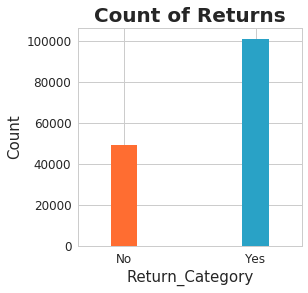

In [14]:
### for holiday ##
target_dist(data_h)

/opt/anaconda/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


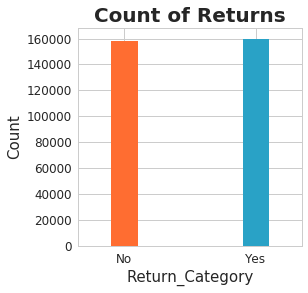

In [15]:
## for non_holiday ###
target_dist(data_nh)

#### Create dummies

In [24]:
data_h_d=dummies(data_h)
data_nh_d=dummies(data_nh)

In [43]:
data_h_d.shape

(150058, 70)

#### Split into test and train

In [44]:
data_h_d['return_status_repurchase'] = le.fit_transform(data_h_d['return_status_repurchase'])
X_h = data_h_d.drop('return_status_repurchase',axis=1)
y_h = data_h_d['return_status_repurchase']
X_train_holiday, X_test_holiday, y_train_holiday, y_test_holiday = train_test_split(X_h,y_h,test_size=0.2, random_state=42)
print("\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n")
print("train_data_shape",X_train_holiday.shape)
print("test_data_shape",X_test_holiday.shape)
print("\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n")
print("test_distribution of target", "\n 1 : ",y_test_holiday.sum()/y_test_holiday.size,"\n 0 : ",1-(y_test_holiday.sum()/y_test_holiday.size))
print("train_distribution of target","\n 1 : ",y_train_holiday.sum()/y_train_holiday.size,"\n 0 : ",1-(y_train_holiday.sum()/y_train_holiday.size) )

data_nh_d['return_status_repurchase'] = le.fit_transform(data_nh_d['return_status_repurchase'])
X_nh = data_nh_d.drop('return_status_repurchase',axis=1)
y_nh = data_nh_d['return_status_repurchase']
X_train_Non_holiday, X_test_Non_holiday, y_train_Non_holiday, y_test_Non_holiday = train_test_split(X_nh,y_nh,test_size=0.2, random_state=42)
print("\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n")
print("train_data_shape",X_train_Non_holiday.shape)
print("test_data_shape",X_test_Non_holiday.shape)
print("\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n")
print("test_distribution of target", "\n 1 : ",y_test_Non_holiday.sum()/y_test_Non_holiday.size,"\n 0 : ",1-(y_test_Non_holiday.sum()/y_test_Non_holiday.size))
print("train_distribution of target","\n 1 : ",y_train_Non_holiday.sum()/y_train_Non_holiday.size,"\n 0 : ",1-(y_train_Non_holiday.sum()/y_train_Non_holiday.size) )



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

train_data_shape (120046, 69)
test_data_shape (30012, 69)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

test_distribution of target 
 1 :  0.6730307876849261 
 0 :  0.3269692123150739
train_distribution of target 
 1 :  0.6729753594455459 
 0 :  0.3270246405544541

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

train_data_shape (254325, 69)
test_data_shape (63582, 69)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

test_distribution of target 
 1 :  0.5014626781164481 
 0 :  0.49853732188355193
train_distribution of target 
 1 :  0.5038238474393001 
 0 :  0.4961761525606999


#### Model 

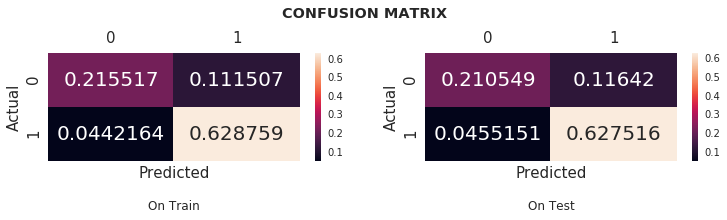


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

accuracy_on_train :  0.8442763607283874

 accuracy_on_test :  0.8380647740903638

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~`~~~


 classification report on Train : 
              precision    recall  f1-score   support

          0       0.82      0.64      0.72      9813
          1       0.84      0.93      0.89     20199

avg / total       0.84      0.84      0.83     30012


 classification report on Test : 
              precision    recall  f1-score   support

          0       0.83      0.66      0.73     39258
          1       0.85      0.93      0.89     80788

avg / total       0.84      0.84      0.84    120046

-------------------------------
 Feature_Importance plot
--------------------------------


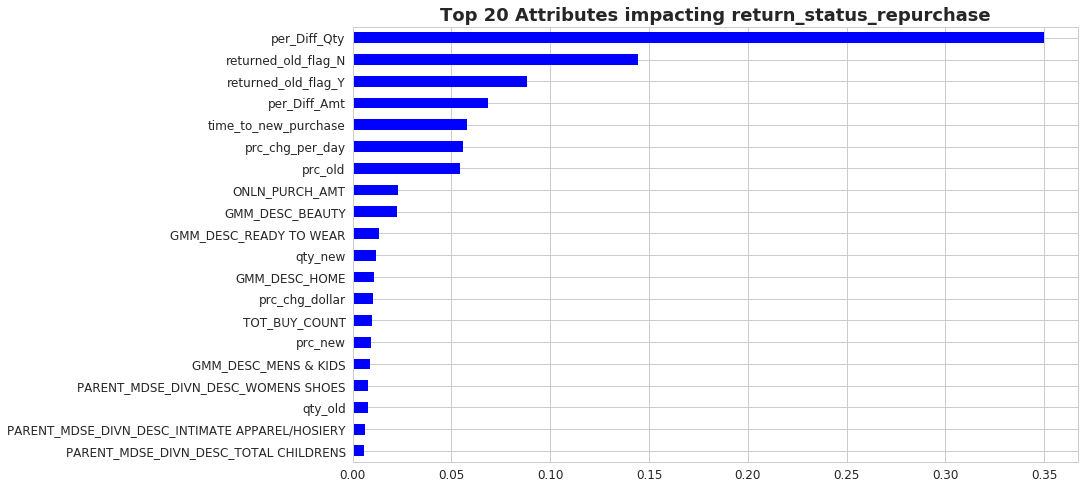

---------------------------------
 Roc-curve
--------------------------------------------
   cutoff  Accuracy_Score       TPR       FPR
0     0.1        0.722740  0.999988  0.847802
1     0.2        0.778851  0.995952  0.667915
2     0.3        0.817628  0.981396  0.519385
3     0.4        0.835130  0.961343  0.424601
4     0.5        0.844276  0.934297  0.340975
5     0.6        0.843118  0.892979  0.259489
6     0.7        0.822385  0.821681  0.176168
7     0.8        0.758093  0.685003  0.091497
8     0.9        0.585892  0.394192  0.019614


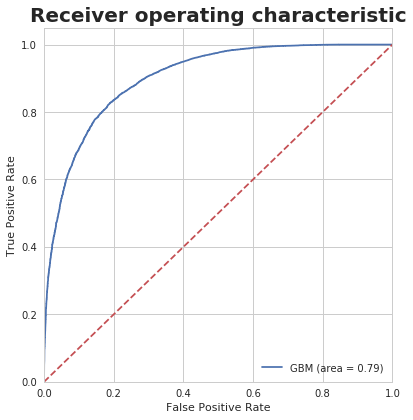

In [48]:
model(X_train_holiday,y_train_holiday,X_test_holiday,y_test_holiday,train_on='holiday')  ### Train : Holiday , Test : Holiday

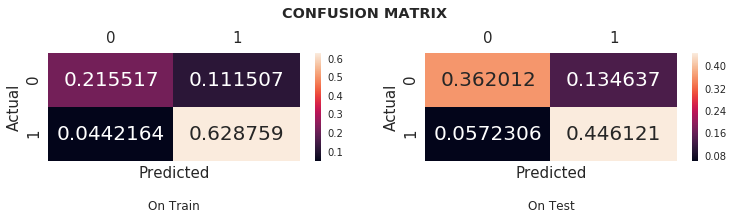


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

accuracy_on_train :  0.8442763607283874

 accuracy_on_test :  0.808132567071502

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~`~~~


 classification report on Train : 
              precision    recall  f1-score   support

          0       0.86      0.73      0.79    157888
          1       0.77      0.89      0.82    160019

avg / total       0.82      0.81      0.81    317907


 classification report on Test : 
              precision    recall  f1-score   support

          0       0.83      0.66      0.73     39258
          1       0.85      0.93      0.89     80788

avg / total       0.84      0.84      0.84    120046

-------------------------------
 Feature_Importance plot
--------------------------------


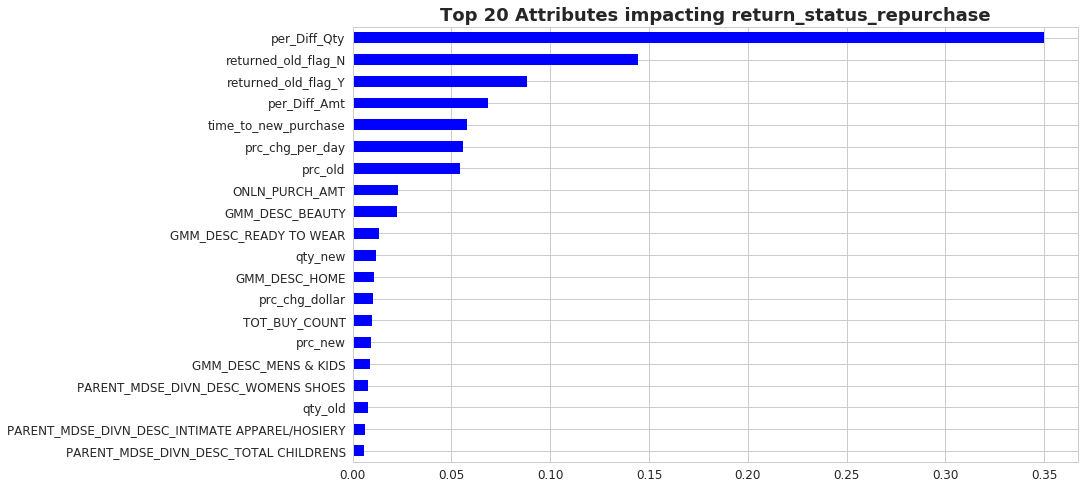

---------------------------------
 Roc-curve
--------------------------------------------
   cutoff  Accuracy_Score       TPR       FPR
0     0.1        0.722740  0.999988  0.847802
1     0.2        0.778851  0.995952  0.667915
2     0.3        0.817628  0.981396  0.519385
3     0.4        0.835130  0.961343  0.424601
4     0.5        0.844276  0.934297  0.340975
5     0.6        0.843118  0.892979  0.259489
6     0.7        0.822385  0.821681  0.176168
7     0.8        0.758093  0.685003  0.091497
8     0.9        0.585892  0.394192  0.019614


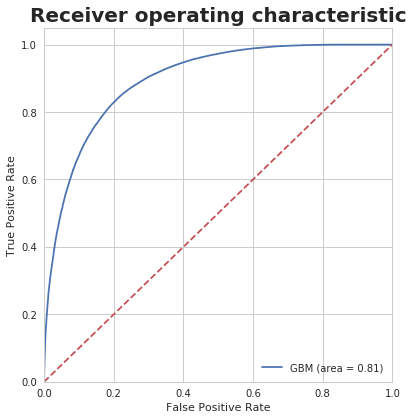

In [49]:
model(X_train_holiday,y_train_holiday,X_nh,y_nh,train_on='holiday') #### Train: Holiday ,Test: Non_holiday 

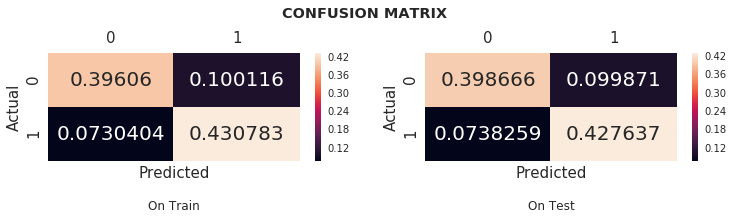


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

accuracy_on_train :  0.8268436056227269

 accuracy_on_test :  0.8263030417413734

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~`~~~


 classification report on Train : 
              precision    recall  f1-score   support

          0       0.84      0.80      0.82     31698
          1       0.81      0.85      0.83     31884

avg / total       0.83      0.83      0.83     63582


 classification report on Test : 
              precision    recall  f1-score   support

          0       0.84      0.80      0.82    126190
          1       0.81      0.86      0.83    128135

avg / total       0.83      0.83      0.83    254325

-------------------------------
 Feature_Importance plot
--------------------------------


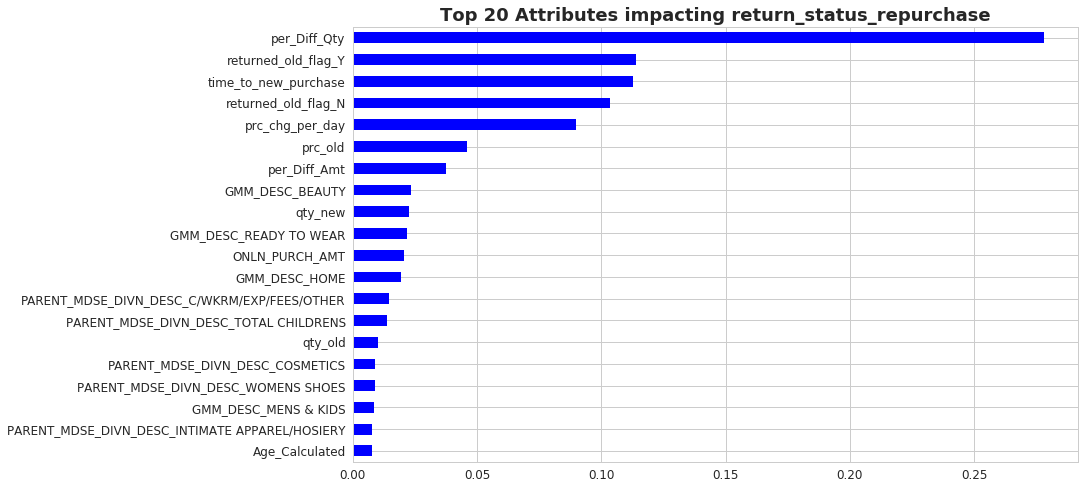

---------------------------------
 Roc-curve
--------------------------------------------
   cutoff  Accuracy_Score       TPR       FPR
0     0.1        0.635624  0.999048  0.733402
1     0.2        0.746246  0.980942  0.492068
2     0.3        0.794759  0.949803  0.362675
3     0.4        0.818441  0.909463  0.273984
4     0.5        0.826844  0.855028  0.201775
5     0.6        0.820922  0.781535  0.139084
6     0.7        0.791975  0.668631  0.082780
7     0.8        0.719347  0.476053  0.033608
8     0.9        0.540041  0.088735  0.001696


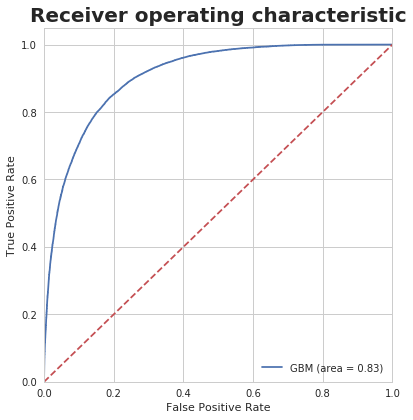

In [50]:
model(X_train_Non_holiday,y_train_Non_holiday,X_test_Non_holiday,y_test_Non_holiday,train_on='non_holiday') #### Train: Non_Holiday ,Test: Non_holiday

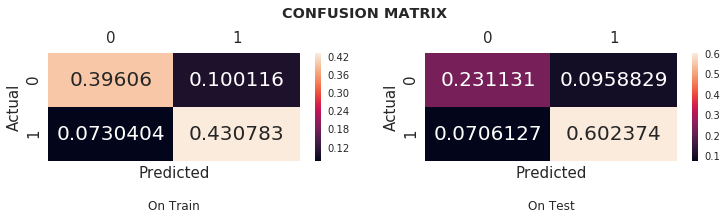


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

accuracy_on_train :  0.8268436056227269

 accuracy_on_test :  0.8335043783070546

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~`~~~


 classification report on Train : 
              precision    recall  f1-score   support

          0       0.77      0.71      0.74     49071
          1       0.86      0.90      0.88    100987

avg / total       0.83      0.83      0.83    150058


 classification report on Test : 
              precision    recall  f1-score   support

          0       0.84      0.80      0.82    126190
          1       0.81      0.86      0.83    128135

avg / total       0.83      0.83      0.83    254325

-------------------------------
 Feature_Importance plot
--------------------------------


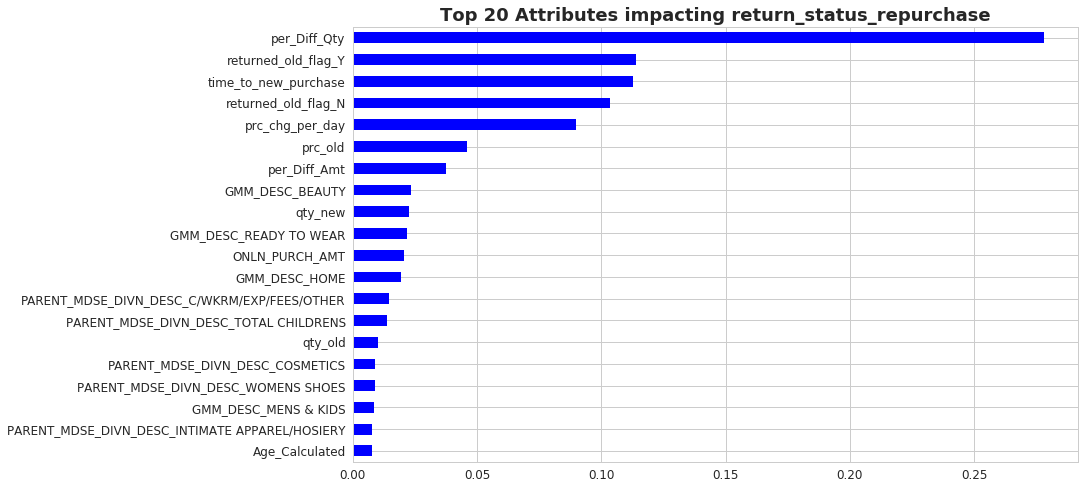

---------------------------------
 Roc-curve
--------------------------------------------
   cutoff  Accuracy_Score       TPR       FPR
0     0.1        0.635624  0.999048  0.733402
1     0.2        0.746246  0.980942  0.492068
2     0.3        0.794759  0.949803  0.362675
3     0.4        0.818441  0.909463  0.273984
4     0.5        0.826844  0.855028  0.201775
5     0.6        0.820922  0.781535  0.139084
6     0.7        0.791975  0.668631  0.082780
7     0.8        0.719347  0.476053  0.033608
8     0.9        0.540041  0.088735  0.001696


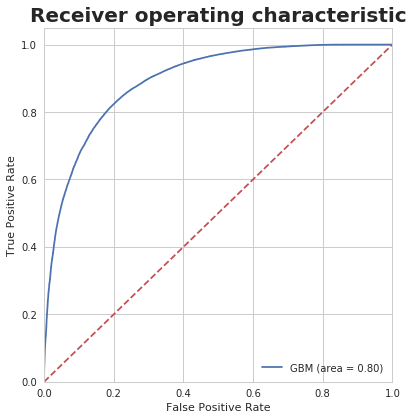

In [51]:
model(X_train_Non_holiday,y_train_Non_holiday,X_h,y_h,train_on='non_holiday')  ## Train : Non-holiday , Test: Holiday

In [52]:
# df=final_h
# df2=cust_ret_data
# df3=RFM_data_h
# df4=cust_data
# df1=sales_data_before_transformation(main_data_h)